### Apply phase-edge encoding PID on data

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_coupling_analysis")

In [2]:
import argparse
import os

import jax
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.conn import conn_io
from frites.io import check_attrs, logger, set_log_level
from frites.utils import parallel_func
from hoi.core import get_mi
from mne.filter import filter_data
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

from src.metrics.spectral import xr_psd_array_multitaper
from src.session import session

# from src.session import session
from src.util import _extract_roi, get_dates

/home/INT/lima.v/projects/phase_coupling_analysis/src/config.py


###############################################################################
##### Functions
###############################################################################

In [3]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3, color="b"
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color=color,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches


def detect_peak_frequencies(power=None, prominence=0.01, verbose=False):

    assert power.ndim == 2
    assert isinstance(power, xr.DataArray)

    roi, freqs = power.roi.data, power.freqs.data
    n_roi = len(roi)

    rois = []
    peak_freqs = []
    peak_prominences = []

    __iter = range(n_roi)
    for i in tqdm(__iter) if verbose else __iter:
        peak_index, peak_info = find_peaks(power[i, :], prominence=prominence)
        peak_freqs += [freqs[peak_index]]
        peak_prominences += [peak_info["prominences"]]
        rois += [[roi[i]] * len(peak_index)]

    return peak_freqs, peak_prominences, rois

In [4]:
def load_session_data(root, sid, monkey, align):
    # Instantiate class
    ses = session(
        raw_path=root,
        monkey=monkey,
        date=sid,
        session=1,
        slvr_msmod=False,
        only_unique_recordings=False,
        align_to=align,
        evt_dt=[-0.65, 2.0],
    )

    # Read data from .mat files
    ses.read_from_mat(verbose=False)

    # Load XYZ coordinates
    coords = np.concatenate(
        (ses.get_xy_coords(), ses.recording_info["depth"][:, None]), axis=1
    )

    # Filtering by trials
    data_task = ses.filter_trials(trial_type=[1], behavioral_response=[1])
    data_fixation = ses.filter_trials(trial_type=[2], behavioral_response=None)

    attrs_task, attrs_fixation = data_task.attrs, data_fixation.attrs

    stim = np.hstack((attrs_task["stim"], attrs_fixation["stim"]))
    t_cue_on = np.hstack((attrs_task["t_cue_on"], attrs_fixation["t_cue_on"]))
    t_cue_off = np.hstack((attrs_task["t_cue_off"], attrs_fixation["t_cue_off"]))
    t_match_on = np.hstack((attrs_task["t_match_on"], attrs_fixation["t_match_on"]))

    np.nan_to_num(stim, nan=6, copy=False)

    data = xr.concat((data_task, data_fixation), "trials")
    data.attrs = attrs_task
    data.attrs["stim"] = stim
    data.attrs["t_cue_on"] = t_cue_on
    data.attrs["t_cue_off"] = t_cue_off
    data.attrs["t_match_on"] = t_match_on
    data.attrs["x"] = coords[:, 0]
    data.attrs["y"] = coords[:, 1]
    data.attrs["z"] = coords[:, 2]

    # ROIs with channels
    rois = [
        f"{roi}_{channel}" for roi, channel in zip(data.roi.data, data.channels_labels)
    ]
    data = data.assign_coords({"roi": rois})
    # data.attrs = attrs
    data.values *= 1e6

    # return node_xr_remove_sca(data)
    return data

In [5]:
def create_epoched_data(data):
    t_match_on = (data.attrs["t_match_on"] - data.attrs["t_cue_on"]) / data.fsample
    t_match_on = np.round(t_match_on, 1)

    epoch_data = []

    for i in range(data.sizes["trials"]):
        stages = [
            [-0.4, 0.0],
            [0, 0.4],
            [0.5, 0.9],
            [0.9, 1.3],
            [t_match_on[i] - 0.4, t_match_on[i]],
        ]

        temp = []

        for t_i, t_f in stages:
            temp += [data[i].sel(time=slice(t_i, t_f)).data]

        epoch_data += [np.stack(temp, axis=-2)]

    epoch_data = xr.DataArray(
        np.stack(epoch_data),
        dims=("trials", "roi", "epochs", "time"),
        coords={
            "trials": data.trials,
            "roi": data.roi,
        },
        attrs=data.attrs,
    )

    return epoch_data

In [6]:
def get_filtered_data(data, bands, band_id):

    f_l, f_h = bands[band_id]

    temp = []

    temp = filter_data(
        data.values, data.fsample, f_l, f_h, n_jobs=10, verbose=False, method="iir"
    )
    temp = np.expand_dims(temp, 2)

    data = xr.DataArray(
        temp,
        # np.stack(temp, axis=2),
        dims=("trials", "roi", "freqs", "times"),
        coords={
            "trials": data.trials,
            "roi": data.roi,
            "freqs": freqs[band_id],
            "times": data.time.values,
        },
        attrs=data.attrs,
    )

    return data

In [7]:
def _phase_diff(w, x_s, x_t, kw_para):
    """
    Compute the pairwise phase difference between two sets of time-series data.

    Parameters
    ----------
    w : ndarray
        The phase time-series array with shape (n_trials, n_rois, n_freqs, n_times),
        representing the instantaneous phase values.
    x_s : list of int
        List of source indices specifying which regions of interest (ROIs) to compute phase differences from.
    x_t : list of int
        List of target indices specifying which regions of interest (ROIs) to compute phase differences to.
    kw_para : dict
        Dictionary of keyword arguments for parallel computation (e.g., number of jobs, verbosity).

    Returns
    -------
    ndarray
        Array of pairwise phase differences between each source-target pair.
        The shape of the output will be (n_trials, n_pairs, n_freqs, n_times).

    Notes
    -----
    The function computes phase differences between the time-series from the specified ROIs,
    then uses `np.unwrap` to handle phase wrapping across 2π discontinuities.
    Parallel computation is utilized for efficiency.
    """

    def pairwise_phase_diff(w_x, w_y):
        return np.unwrap(w[:, w_x, :, :] - w[:, w_y, :, :])

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_phase_diff, **kw_para)

    # compute the single trial coherence
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def hilbert_decomposition(
    data,
    sfreq=None,
    times=None,
    roi=None,
    bands=None,
    n_jobs=1,
    decim=1,
    verbose=None,
    dtype=np.float32,
    **kw_links,
):
    """
    Perform Hilbert decomposition on time-series data to extract power, phase, and phase differences.

    Parameters
    ----------
    data : xarray.DataArray or ndarray
        The input time-series data. Expected to be in the shape (n_trials, n_rois, n_times).
    sfreq : float, optional
        The sampling frequency of the data in Hz. Required for band-pass filtering.
    times : ndarray, optional
        The time points corresponding to the data samples.
    roi : list or ndarray, optional
        The regions of interest (ROIs) to analyze. Can be indices or names corresponding to the data.
    bands : list of tuple, optional
        The frequency bands to filter the data. Each tuple should contain the low and high frequency (in Hz) of the band.
    n_jobs : int, optional
        The number of parallel jobs to use for computations (default is 1).
    verbose : bool or int, optional
        Verbosity level for logging.
    dtype : data-type, optional
        The data type of the returned arrays (default is np.float32).
    **kw_links : dict
        Additional arguments for connection analysis.

    Returns
    -------
    power : xarray.DataArray
        Power time-series of the filtered signals across the specified frequency bands.
        Dimensions: (n_trials, n_rois, n_freqs, n_times).
    phase : xarray.DataArray
        Phase time-series of the filtered signals across the specified frequency bands.
        Dimensions: (n_trials, n_rois, n_freqs, n_times).
    delta_phase : xarray.DataArray
        Pairwise phase differences between the ROIs across frequency bands.
        Dimensions: (n_trials, n_roi_pairs, n_freqs, n_times).

    Notes
    -----
    The Hilbert decomposition is applied after band-pass filtering the data to extract the analytic signal,
    from which power and phase are derived. Pairwise phase differences are computed in parallel
    for specified pairs of ROIs.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    kw_links.update({"directed": False, "net": False})
    data, cfg = conn_io(
        data,
        times=times,
        roi=roi,
        agg_ch=False,
        win_sample=None,
        sfreq=sfreq,
        verbose=verbose,
        name="Hilbert Decomposition",
        kw_links=kw_links,
    )

    # Extract variables
    x, trials, attrs = data.data, data["y"].data, cfg["attrs"]
    times, _ = data["times"].data, len(trials)
    x_s, x_t, roi_p, roi = cfg["x_s"], cfg["x_t"], cfg["roi_p"], data["roi"].data
    _, sfreq = cfg["blocks"], cfg["sfreq"]
    n_pairs, f_vec, n_freqs = len(x_s), np.mean(bands, axis=1), len(bands)
    # If no bands are passed use broadband signal

    times = times[::decim]

    _dims = ("trials", "roi", "freqs", "times")
    _coord_nodes = (trials, roi, f_vec, times)
    _coord_links = (trials, roi_p, f_vec, times)

    # Filter data in the specified bands
    x_filt = []

    for f_low, f_high in bands:
        x_filt += [
            xr.DataArray(
                filter_data(
                    x,
                    sfreq,
                    f_low,
                    f_high,
                    n_jobs=n_jobs,
                    verbose=verbose,
                    method="iir",
                ),
                dims=data.dims,
                coords=data.coords,
                attrs=attrs,
            )
        ]

    x_filt = xr.concat(x_filt, "freqs").transpose("trials", "roi", "freqs", "times")

    # Hilbert coefficients
    h = scipy.signal.hilbert(x_filt, axis=3)[..., ::decim]

    # Power and phase time-series
    power = (h * np.conj(h)).real
    phase = np.angle(h)

    # Compute phase-differences in parellel
    # show info
    logger.info(
        f"Computing pairwise phase difference (n_pairs={n_pairs}, " f"n_bands={n_freqs}"
    )
    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)
    delta_phase = np.stack(_phase_diff(phase, x_s, x_t, kw_para), axis=1)

    # Wrapp to xrray
    power = xr.DataArray(
        power, dims=_dims, coords=_coord_nodes, attrs=attrs, name="power"
    )
    phase = xr.DataArray(
        phase, dims=_dims, coords=_coord_nodes, attrs=attrs, name="phase"
    )
    delta_phase = xr.DataArray(
        delta_phase, dims=_dims, coords=_coord_links, attrs=attrs, name="phase_diff"
    )

    return power.astype(dtype), phase.astype(dtype), delta_phase.astype(dtype)

In [8]:
mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

###############################################################################
##### Get session and monkey
###############################################################################

In [9]:
align = "cue"
monkey = "lucy"
session_number = get_dates(monkey)[0]

In [10]:
_ROOT = os.path.expanduser("/home/INT/lima.v/data/GrayLab/")

In [11]:
data = load_session_data(_ROOT, session_number, monkey, align)
attrs = data.attrs
stim = data.stim.astype(int)

In [12]:
mask = stim != 6
data = data.isel(trials=mask)
stim = stim[mask]

In [13]:
labels = np.tile(np.expand_dims(stim, 1), data.sizes["time"])

In [14]:
roi_sel_pairs = np.array(
    [
        "a9/46D_9-TPt_141",
        "a7A_181-a9/46D_9",
        "a9/46D_9-DP_191",
        "a9/46D_9-PIP_193",
        "a7A_181-a8B_11",
        "a8B_11-DP_191",
        "a8B_11-PIP_193",
        "a7A_181-a8B_12",
        "a8B_12-DP_191",
        "a8B_12-PIP_193",
        "a7B_121-F7_13",
        "a7A_156-F7_13",
        "a7A_181-F7_13",
        "DP_191-F7_13",
        "F7_13-PIP_193",
        "a5_149-F7_14",
        "a7A_156-a8M_17",
        "a7A_181-a8M_17",
        "a8M_17-DP_191",
        "a8M_17-PIP_193",
        "a7A_156-a8B_18",
        "a7A_181-a8B_18",
        "a8B_18-DP_191",
        "a8B_18-PIP_193",
        "a5_149-F7_20",
        "a7A_181-a8L_21",
        "a8L_21-DP_191",
        "a5_172-F2_28",
        "F2_28-V6A_183",
        "a44_29-a7A_181",
        "a44_29-DP_191",
        "F2_36-V6A_183",
        "a7A_181-a8L_39",
        "a8L_39-DP_191",
        "a8L_39-PIP_193",
    ],
    dtype="<U16",
)

roi_sel_pairs = np.array(["a7A_156-PIP_193"])

roi_sel = np.unique(_extract_roi(roi_sel_pairs, "-"))

In [40]:
bands = [[6, 14]]

_, _, delta_phase = hilbert_decomposition(
    data.sel(roi=roi_sel), data.fsample, times="time", bands=bands, roi="roi", decim=3
)

Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names


Setting up band-pass filter from 6 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 14.00 Hz: -6.02, -6.02 dB



Computing pairwise phase difference (n_pairs=1, n_bands=1


  0%|          |  : 0/1 [00:00<?,       ?it/s]

In [41]:
delta_phase = delta_phase.isel(freqs=0)

###############################################################################
##### Compute MI
###############################################################################

In [42]:
labels = np.tile(np.expand_dims(stim, 1), delta_phase.sizes["times"])

In [43]:
stim_perm = np.random.permutation(stim)
labels_perm = np.tile(np.expand_dims(stim_perm, 1), delta_phase.sizes["times"])

In [44]:
from functools import partial


@partial(jax.vmap, in_axes=(0, None))
def _loop(data, labels):
    return mi_fcn_time(
        data[None],
        labels[None],
        False,
        True,
    )


_loop_surrogate = jax.vmap(_loop, in_axes=(None, 0))

In [45]:
MI = _loop(delta_phase.transpose("roi", "trials", "times").data, labels)

In [46]:
n_boots = 500

MI_surr = []

for i in tqdm(range(n_boots)):

    stim_perm = np.random.permutation(stim)
    labels_perm = np.tile(np.expand_dims(stim_perm, 1), delta_phase.sizes["times"])

    MI_surr += [
        _loop(delta_phase.transpose("roi", "trials", "times").data, labels_perm)
    ]

100%|█████████████████████████████████████████| 500/500 [00:39<00:00, 12.52it/s]


In [47]:
MI = xr.DataArray(
    np.stack(MI), dims=("roi", "times"), coords=(delta_phase.roi, delta_phase.times)
)

In [48]:
MI_surr = xr.DataArray(
    np.stack(MI_surr),
    dims=("boot", "roi", "times"),
    coords=(range(n_boots), delta_phase.roi, delta_phase.times),
)

###############################################################################
##### Compute statistics
###############################################################################

In [49]:
from frites.workflow import WfStats
from mne.stats import fdr_correction
from scipy.stats import ttest_ind

In [50]:
stats = WfStats()

Definition of a non-parametric statistical workflow


In [51]:
x = [MI.sel(roi=roi_).data[None] for roi_ in MI.roi.values]
y = [MI_surr.sel(roi=roi_).data[:, None] for roi_ in MI.roi.values]

In [52]:
pv, tv = stats.fit(x, y, inference="ffx", mcp="cluster", tail=1)

    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=0.008598552085459232; tail=1)


In [53]:
MI_thr = MI * (pv < 0.01).T

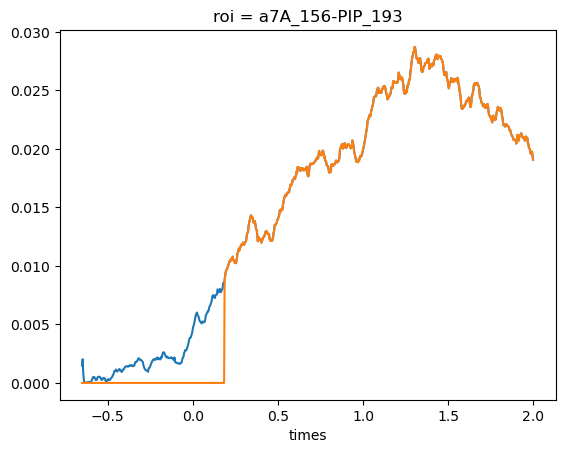

In [54]:
MI[0].plot()
MI_thr[0].plot()

###############################################################################
##### Time-frequency
###############################################################################

In [55]:
freqs = np.linspace(2.5, 40, 30)
bands = np.stack((freqs - 4, freqs + 4), 1)
bands = np.clip(bands, 0, np.inf)
_, _, S = hilbert_decomposition(
    data.sel(roi=roi_sel),
    data.fsample,
    times="time",
    bands=bands,
    roi="roi",
    decim=3,
    verbose=False,
)

In [56]:
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

In [57]:
labels = np.tile(np.expand_dims(stim, (1, 2)), (S.sizes["times"], S.sizes["freqs"]))

In [58]:
from functools import partial


@partial(jax.vmap, in_axes=(0, None))
def _loop(data, labels):
    return mi_fcn_time_frequency(
        data[None],
        labels[None],
        False,
        True,
    )


_loop_surrogate = jax.vmap(_loop, in_axes=(None, 0))

In [59]:
MI = _loop(S.transpose("roi", "trials", "times", "freqs").data, labels)

In [60]:
n_boots = 1000

MI_surr = []

for i in tqdm(range(n_boots)):

    stim_perm = np.random.permutation(stim)
    labels_perm = labels = np.tile(
        np.expand_dims(stim_perm, (1, 2)), (S.sizes["times"], S.sizes["freqs"])
    )
    MI_surr += [_loop(S.transpose("roi", "trials", "times", "freqs").data, labels_perm)]

100%|███████████████████████████████████████| 1000/1000 [38:39<00:00,  2.32s/it]


In [61]:
MI = xr.DataArray(
    MI,
    dims=("roi", "times", "freqs"),
    coords=(
        ["x"],
        S.times.values,
        S.freqs.values,
    ),
)

In [62]:
MI_surr = xr.DataArray(
    np.stack(MI_surr),
    dims=("boot", "roi", "times", "freqs"),
    coords=(range(n_boots), ["x"], S.times, S.freqs),
)

In [63]:
stats = WfStats()

Definition of a non-parametric statistical workflow


In [64]:
x = [np.asarray(MI.sel(roi=roi_).data[None]) for roi_ in MI.roi.values]
y = [np.asarray(MI_surr.sel(roi=roi_).data[:, None]) for roi_ in MI.roi.values]

In [65]:
pv, tv = stats.fit(x, y, inference="ffx", mcp="cluster", tail=1)

    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=0.008617059327661991; tail=1)


In [66]:
!python -m pip install -U scikit-image

from skimage import measure

/home/INT/lima.v/anaconda3/envs/test_env/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [67]:
mask = (pv.squeeze().T <= 0.01).astype(int)
contours = measure.find_contours(mask, level=0.5)

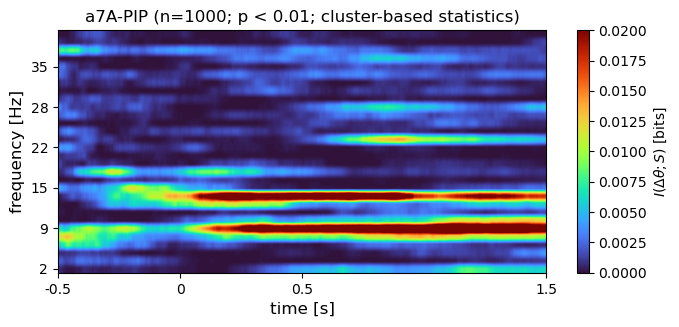

In [68]:
plt.figure(figsize=(20 / 2.54, 8 / 2.54))
extent = [-0.65, 2, freqs[0], freqs[-1]]
ax = plt.imshow(
    MI[0].T,
    aspect="auto",
    origin="lower",
    vmax=0.02,
    cmap="turbo",
)


cbar = plt.colorbar()
plt.title("a7A-PIP (n=1000; p < 0.01; cluster-based statistics)", fontsize=12)
plt.ylabel("frequency [Hz]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)
cbar.set_label(r"$I(\Delta\theta; S)$ [bits]")

height, width = mask.shape
x_min, x_max, y_min, y_max = extent
x_scale = (x_max - x_min) / width
y_scale = (y_max - y_min) / height


# Plot contours with scaled coordinates
for contour in contours:
    x = contour[:, 1]
    y = contour[:, 0]
    plt.plot(x, y, color="w", linewidth=3)


tkx = [-0.5, 0, 0.5, 1.5]
pos = [np.argmin(np.abs(data.time.values[::3] - tk)) for tk in tkx]
plt.xticks(pos, tkx)
plt.yticks(
    [0, 5, 10, 15, 20, 25], np.round(freqs[[0, 5, 10, 15, 20, 25]], 0).astype(int)
)
plt.xlim(pos[0], pos[-1])


plt.savefig("figures/a7A_PIP_encoding.png", bbox_inches="tight")